# Offenive evolution of LeBron James in NBA
In this notebook we present an analysis of the evolution of LeBron James' offensive game, in terms of shot selection and efficiency, over the course of his NBA career. In particular, we analyze data from the regular seasons from 2003-2004 to 2019-2024, with the aim of understanding how his game has changed over the years and how this has influenced the offensive production of his teams.
To be more specific, we will focus on the following aspects:
- Shot selection: how has LeBron's shot selection evolved over the years? Has he become more efficient in terms of shot selection?
- Efficiency: how has LeBron's shooting efficiency evolved over the years? Has he become a more efficient scorer?
- Impact on team performance: how has LeBron's offensive evolution influenced the performance of his teams? Has he been able to improve the offensive production of his teams over the years?


## Shot selection

To analyze LeBron's shot selection over the years, we will look at the distribution of his shot attempts by shot location (restricted area, paint, mid-range, corner 3, ...). We will compare the distribution of shot attempts in different eras to see how LeBron's shot selection has evolved over time.
In order to do this, we will use a self arrenged version of EDU VADILLO kaggle dataset, which contains detailed information about LeBron's shot attempts, including shot location, shot type, and outcome. The dataset can be found here: https://www.kaggle.com/datasets/eduvadillo/lebron-james-career-shots
In this very first part of the analysis we will draw a heatmap of LeBron's shot attempts by shot location for different eras, in order to visualize how his shot selection has evolved over the years.


First, let's import the necessary libraries and load the dataset:

In [713]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from shapely.geometry import Polygon


# Load the data
df = pd.read_pickle("LeBronShots.pickle")

df2 = pd.read_pickle("LebronStats.pickle")

df_Mean = pd.read_pickle("LeBron_Win%_Mean.pickle")

### NBA Court Chart
Now we can begin our work. First, we need to define the NBA court chart, which will serve as the base for plotting the shot data. The following code defines a function that generates a basketball court chart using the matplotlib library. This function takes in input the axis object on which the court will be plotted and returns the axis object for further customization.
This function is a modified version of the one provided by Zach Gilbert in his project "Visualizing NBA Shots with py-Goldsberry" which can be found here https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb.

In [714]:
#note: this function has benn optimized to plot more than one court at the same time

# Parameters
color = 'black'
lw = 2

def draw_court(ax=None):
    if ax is None:
        ax = plt.gca()

    # Elements of the court
    # Basketball hoop
    hoop = patches.Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Backboard
    backboard = patches.Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Paint
    paint_lines = patches.Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    
    # Free throw top arc
    free_throw = patches.Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    
    # Restricted area
    restricted_area = patches.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    # Three point line
    # Side three point lines
    right_corner_side_line = patches.Rectangle((-220, -47.5), 0, 137.5, linewidth=lw, color=color)
    left_corner_side_line = patches.Rectangle((220, -47.5), 0, 137.5, linewidth=lw, color=color)

    # Three point arc
    three_arc = patches.Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    # Outer lines
    outer_lines = patches.Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)

    # List of court elements
    court_elements = [hoop, backboard, paint_lines, free_throw, restricted_area, right_corner_side_line, left_corner_side_line, three_arc, outer_lines]

    # Add the elements to the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax


### Area Division Function
Once we have defined the court chart, we can implement a new function to generate the areas into which the court is divided. Specifically, we will divide the court into 10 areas:
- Restricted Area
- In The Paint (Non-RA)
- Mid-Range Left
- Mid-Range Right
- Mid-Range Center
- Left Corner 3
- Right Corner 3
- Three Point Left
- Three Point Right
- Three Point Center

This function utilizes Polygon objects from the shapely library to define specific areas. We start by constructing several polygons using the coordinates of the points that define the vertices of these areas. Then, we employ set operations on these polygons to create the desired areas.

The function returns a dictionary that maps each area to its corresponding polygon object.

In [715]:
import numpy as np
from shapely.geometry import Polygon

# Function to create arc points
def create_arc_points(radius, start_angle, end_angle, num_points=100):
    theta = np.linspace(np.radians(start_angle), np.radians(end_angle), num_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return np.column_stack((x, y))

# Create arc points
arc_x, arc_y = create_arc_points(237.5, 22, 158).T

# Create restricted area points
restricted_x, restricted_y = create_arc_points(40, 0, 180).T

# Define points for different shooting areas
Arc_points = np.column_stack((arc_x, arc_y))

ThreePointArea_Left_points = [(250, 422.5), (250, 90), (220, 90), (80, 142.5), (120, 422.5)]
ThreePointArea_Center_points = [(80, 142.5), (120, 422.5), (-120, 422.5), (-80, 142.5)]
ThreePointArea_Right_points = [(-250, 422.5), (-250, 90), (-220, 90), (-80, 142.5), (-120, 422.5)]
LeftCornerThree_points = [(220, -47.5), (220, 90), (250, 90), (250, -47.5)]
RightCornerThree_points = [(-220, -47.5), (-220, 90), (-250, 90), (-250, -47.5)]

MidRange_Left_points_Aux = [(120, 422.5), (80, 142.5), (80, -47.5), (220, -47.5), (220, 422.5)]
MidRange_Center_points = [(-80, 142.5), (-120, 422.5), (120, 422.5), (80, 142.5)]
MidRange_Right_points_Aux = [(-120, 422.5), (-80, 142.5), (-80, -47.5), (-220, -47.5), (-220, 422.5)]

Paint_points = [(80, -47.5), (80, 142.5), (-80, 142.5), (-80, -47.5)]

Restricted_Area_points1 = np.column_stack((restricted_x, restricted_y))
Restriced_Area_points2 = [(40, 0), (40, -10), (-40, -10), (-40, 0)]
Restricted_Area_points = np.vstack((Restricted_Area_points1, Restriced_Area_points2))

# Create Polygon objects from points
def create_polygons():
    Arc_Pol = Polygon(Arc_points)
    ThreePointArea_Left_Aux = Polygon(ThreePointArea_Left_points)
    ThreePointArea_Center_Aux = Polygon(ThreePointArea_Center_points)
    ThreePointArea_Right_Aux = Polygon(ThreePointArea_Right_points)
    LeftCornerThree = Polygon(LeftCornerThree_points)
    RightCornerThree = Polygon(RightCornerThree_points)
    MidRange_Left_Aux = Polygon(MidRange_Left_points_Aux)
    MidRange_Center_Aux = Polygon(MidRange_Center_points)
    MidRange_Right_Aux = Polygon(MidRange_Right_points_Aux)
    Paint = Polygon(Paint_points)
    Restricted_Area = Polygon(Restricted_Area_points)

    # Calculate differences to define final areas
    ThreePointArea_Left = ThreePointArea_Left_Aux.difference(Arc_Pol)
    ThreePointArea_Center = ThreePointArea_Center_Aux.difference(Arc_Pol)
    ThreePointArea_Right = ThreePointArea_Right_Aux.difference(Arc_Pol)
    MidRange_Center_Aux1 = MidRange_Center_Aux.difference(ThreePointArea_Center)
    MidRange_Center = MidRange_Center_Aux1.difference(Paint)
    MidRange_Left = MidRange_Left_Aux.difference(ThreePointArea_Left)
    MidRange_Right = MidRange_Right_Aux.difference(ThreePointArea_Right)

    # Create a dictionary with the areas
    areas = {
        'Left Side Mid-Range': MidRange_Left,
        'Right Side Mid-Range': MidRange_Right,
        'Center Mid-Range': MidRange_Center,
        'Left Side Corner 3': LeftCornerThree,
        'Left Side Three Point': ThreePointArea_Left,
        'Right Side Corner 3': RightCornerThree,
        'Right Side Three Point': ThreePointArea_Right,
        'Center Three Point': ThreePointArea_Center,
        'In The Paint (Non Restricted)': Paint,
        'Restricted Area': Restricted_Area
    }
    return areas

In [716]:
# Seasons arrays
cavs_1 = np.array(['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10'])
mia = np.array(['2010-11', '2011-12', '2012-13', '2013-14'])
cavs_2 = np.array(['2014-15', '2015-16', '2016-17', '2017-18'])
lal = np.array(['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'])

# Concatenate seasons arrays
seasons = np.concatenate((cavs_1, mia, cavs_2, lal))

# Initialize discard counts for each zone
discards = {
    'Left Side Mid-Range': 0,
    'Right Side Mid-Range': 0,
    'Center Mid-Range': 0,
    'Left Side Corner 3': 0,
    'Left Side Three Point': 0,
    'Right Side Corner 3': 0,
    'Right Side Three Point': 0,
    'Center Three Point': 0,
    'In The Paint (Non Restricted)': 0,
    'Restricted Area': 0
}

# Initialize lists for each shooting zone
Left_Side_Mid_Range = []
Right_Side_Mid_Range = []
Center_Mid_Range = []
Left_Side_Corner_3 = []
Left_Side_Three_Point = []
Right_Side_Corner_3 = []
Right_Side_Three_Point = []
Center_Three_Point = []
In_The_Paint_Non_Restricted = []
Restricted_Area = []

# Eras labels
eras_label = ['Cleveland Cavs (1)', 'Miami Heat', 'Cleveland Cavs (2)', 'Los Angeles Lakers']

### Shot Distribution Function

Before we plot the shot distribution, there's one final step: calculating the opacity for each area of the court. This can be achieved using two functions:
##### Calculate Shot Distribution
This function determines the shot distribution percentage for a given dataset. It takes the dataset as input and returns a dictionary that maps each area to the number of shots attempted in that area.

Cause we will need to calculate the number of shot attemps for each area then in the work, we define an auxiliary function. It generates a dictionary that maps each area to the number of shots attempted in that area. This function takes in input the dataset and the dictionary of areas and returns the dictionary of shot attempts for each area.

In [717]:
def shots(data):
    # Calculate the number of shots attempted for each area
    LS_Mid = data[(data.Area == 'Left Side(L)') & (data.Zone == 'Mid-Range')].shape[0]
    RS_Mid = data[(data.Area == 'Right Side(R)') & (data.Zone == 'Mid-Range')].shape[0]
    C_Mid = data[(data.Area == 'Center(C)') & (data.Zone == 'Mid-Range')].shape[0]
    LS_Corner = data[(data.Zone == 'Left Corner 3')].shape[0]
    LS_Three = data[(data.Area == 'Left Side(L)') & (data.Zone == 'Above the Break 3')].shape[0]
    RS_Corner = data[(data.Zone == 'Right Corner 3')].shape[0]
    RS_Three = data[(data.Area == 'Right Side(R)') & (data.Zone == 'Above the Break 3')].shape[0]
    C_Three = data[(data.Area == 'Center(C)') & (data.Zone == 'Above the Break 3')].shape[0]
    Paint = data[(data.Zone == 'In The Paint (Non-RA)')].shape[0]
    Restricted = data[(data.Zone == 'Restricted Area')].shape[0]

    # Create a dictionary with the total number of shots attempted for each area
    attempts = {
        'Left Side Mid-Range': LS_Mid,
        'Right Side Mid-Range': RS_Mid,
        'Center Mid-Range': C_Mid,
        'Left Side Corner 3': LS_Corner,
        'Left Side Three Point': LS_Three,
        'Right Side Corner 3': RS_Corner,
        'Right Side Three Point': RS_Three,
        'Center Three Point': C_Three,
        'In The Paint (Non Restricted)': Paint,
        'Restricted Area': Restricted
    }

    return attempts


So we use the previous function to calculate the shot distribution for each era and then plot the shot distribution for each era.

In [718]:
def shot_distribution(data, seasons):
    #Calculate Shot Distribution: This function determines the shot distribution percentage for a given dataset.
    #Parameters:
    #data (DataFrame): The dataset containing shot data.
    #seasons (list of strings): List of seasons to filter the dataset.

    #Returns:
    #dict: A dictionary mapping each area to the percentage of shots attempted in that area.

    # Filter the data by the given seasons
    filtered_data = data[data.Season.isin(seasons)]

    # Get the total number of shots attempted in the filtered dataset
    total_shots = filtered_data.shape[0]

    # Get the number of shots attempted for each area
    attempts = shots(filtered_data)

    # Calculate the shot distribution percentage for each area
    distribution = {area: (attempts[area] / total_shots * 100) for area in attempts.keys()}

    return distribution


##### Calculate Opacity
This function computes the opacity for each area based on the shot distribution. It takes the shot distribution dictionary and the maximum opacity value as inputs and returns a dictionary that maps each area to its corresponding opacity value.

In this script, we define a variable called "max_value," which represents the overall maximum value of the distribution across all eras. This variable is particularly important for our analysis, as it allows us to compare shot distributions from different eras effectively. To ensure accuracy, "max_value" is determined manually by examining and identifying the highest values among the distributions from all eras.

In [719]:
# Calculate shot distribution for each period
distribution_cavs1 = shot_distribution(df, cavs_1)
distribution_mia = shot_distribution(df, mia)
distribution_cavs2 = shot_distribution(df, cavs_2)
distribution_lal = shot_distribution(df, lal)

# Calculate the maximum value for the shot distribution
max_value = max(
    max(distribution_cavs1.values()),
    max(distribution_mia.values()),
    max(distribution_cavs2.values()),
    max(distribution_lal.values())
)

# Calculate the bounds for the color scale
# High percentage
high = 0.7 * max_value

# Medium percentage
medium = 0.25 * max_value

# Low percentage
low = 0.1 * max_value

levels = ['very_low', 'low', 'medium', 'high']


In [720]:
#oltre all'opacità determino un colore. rosso se > 50% di perc di tiri, arancione se tre 35 e 50, giallo altrimenti.

col_and_op = { 'Left Side Mid-Range': ['', 0], 'Right Side Mid-Range': ['', 0], 'Center Mid-Range': ['', 0], 'Left Side Corner 3': ['', 0], 'Left Side Three Point': ['', 0],
               'Right Side Corner 3': ['', 0], 'Right Side Three Point': ['', 0], 'Center Three Point': ['', 0], 'In The Paint (Non Restricted)': ['', 0], 'Restricted Area': ['', 0]}


def color_and_opacity(distribution, alpha):

    #calculate the opacity
    for area in distribution:
        opacity = (distribution[area] * alpha) / max_value
        #update the dictionary
        col_and_op[area][1] = opacity

        #calculate the color
        if distribution[area] > high:
            color = 'darkred'
        elif distribution[area] > medium:
            color = 'red'
        elif distribution[area] > low:
            color = 'darkorange'
        else:
            color = 'yellow'
        #update the dictionary
        col_and_op[area][0] = color

    return col_and_op

### Plot Shot Distribution
Now that we have all the necessary functions in place, we can proceed to plot the shot distribution heatmap. Let's try to plot the shot distribution for LeBron's first run in Cleveland (2003-2004 to 2009-2010).

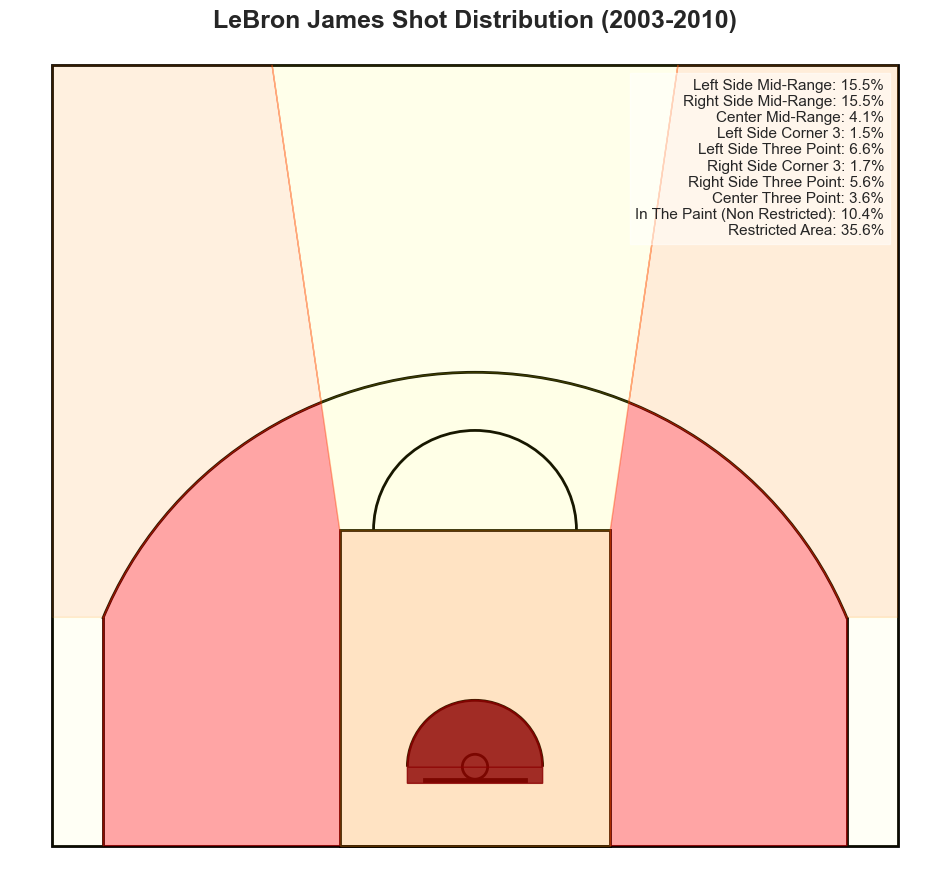

In [721]:
import matplotlib.pyplot as plt

def plot_shot_distribution(distribution, alpha, title):
    # Calculate colors and opacities
    colore_opacita = color_and_opacity(distribution, alpha)

    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(12, 11))

    # Plot the court
    draw_court()  # Assuming you have a function `draw_court()` that plots the basketball court

    # Plot the areas
    areas = create_polygons()  # Assuming you have a function `create_polygons()` that creates polygons for each area
    for area in areas:
        plt.fill(*areas[area].exterior.xy, color=colore_opacita[area][0], alpha=colore_opacita[area][1])

    plt.xlim(-275, 275)
    plt.ylim(-70, 440)
    plt.axis('off')

    plt.title(title, fontsize=18, fontweight='bold')

    # Add a legend box with shot distribution information
    text = '\n'.join([f'{area}: {distribution[area]:.1f}%' for area in distribution.keys()])
    plt.text(0.94, 0.95, text, fontsize=11, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Example usage:
plot_shot_distribution(distribution_cavs1, alpha=1, title='LeBron James Shot Distribution (2003-2010)')


At this stage, we've successfully created a heatmap illustrating LeBron James' shot distribution during his initial stint with the Cleveland Cavaliers. This heatmap visually displays the frequency of shot attempts across various zones on the basketball court, offering valuable insights into LeBron's shot selection during that period. Our next objective is to replicate this process for each distinct phase of LeBron's career in the NBA. This comprehensive approach will allow us to compare and analyze his shot distributions over time, revealing any significant changes or patterns in his shooting tendencies throughout his career.

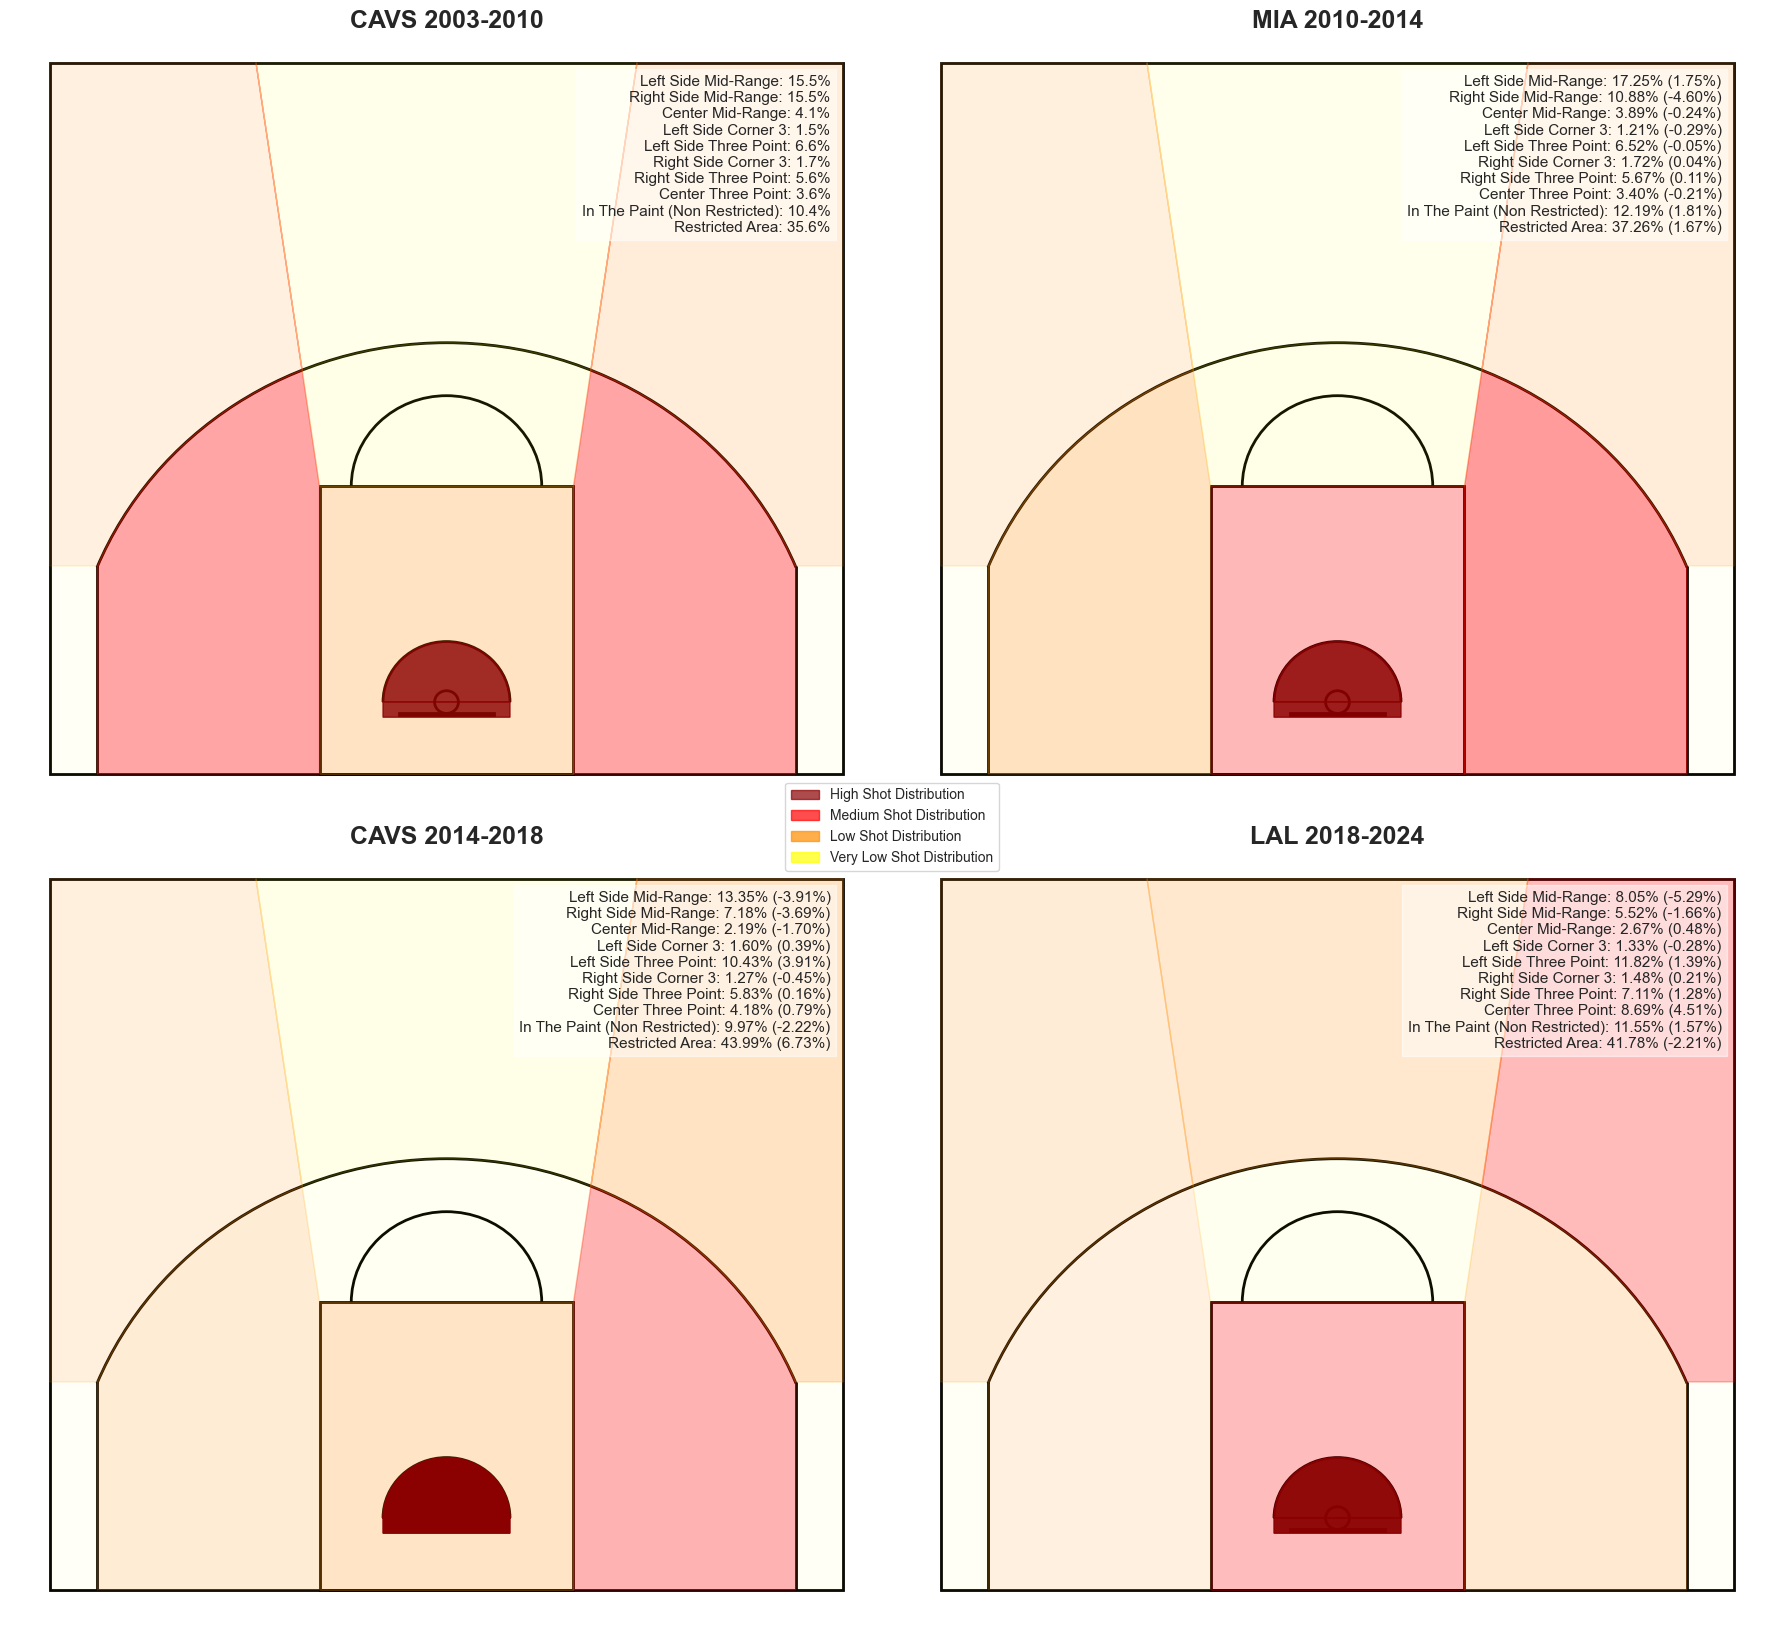

In [722]:
# Funzione per disegnare il campo e riempire le aree
def draw_and_fill(ax, title, distribution, color_opacity):
    draw_court(ax)
    areas = create_polygons()
    for area in areas:
        ax.fill(*areas[area].exterior.xy, color=color_opacity[area][0], alpha=color_opacity[area][1])
    ax.set_xlim(-275, 275)
    ax.set_ylim(-70, 440)
    ax.axis('off')
    ax.set_title(title, fontsize=18, fontweight='bold')

# Funzione per aggiungere la leggenda con la distribuzione dei tiri
def add_legend(ax, distribution, reference_distribution=None):
    if reference_distribution is None:
        text = '\n'.join([f'{area}: {distribution[area]:.1f}%' for area in distribution.keys()])
    else:
        discards = {area: round(distribution[area] - reference_distribution[area], 2) for area in distribution.keys()}
        text = '\n'.join([f'{area}: {distribution[area]:.2f}% ({discards[area]:.2f}%)' for area in distribution.keys()])
    ax.text(0.94, 0.95, text, fontsize=11, verticalalignment='top', horizontalalignment='right', 
            transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Crea la figura e gli assi
fig, axs = plt.subplots(2, 2, figsize=(18, 16.5))

# Disegna e riempi i campi per ciascun periodo
draw_and_fill(axs[0, 0], 'CAVS 2003-2010', distribution_cavs1, color_and_opacity(distribution_cavs1, 1))
draw_and_fill(axs[0, 1], 'MIA 2010-2014', distribution_mia, color_and_opacity(distribution_mia, 1))
draw_and_fill(axs[1, 0], 'CAVS 2014-2018', distribution_cavs2, color_and_opacity(distribution_cavs2, 1))
draw_and_fill(axs[1, 1], 'LAL 2018-2024', distribution_lal, color_and_opacity(distribution_lal, 1))

# Aggiungi le leggende
add_legend(axs[0, 0], distribution_cavs1)
add_legend(axs[0, 1], distribution_mia, distribution_cavs1)
add_legend(axs[1, 0], distribution_cavs2, distribution_mia)
add_legend(axs[1, 1], distribution_lal, distribution_cavs2)

legend_handles = [
    patches.Patch(color='darkred', alpha=0.7, label='High Shot Distribution'),
    patches.Patch(color='red', alpha=0.7, label='Medium Shot Distribution'),
    patches.Patch(color='darkorange', alpha=0.7, label='Low Shot Distribution'),
    patches.Patch(color='yellow', alpha=0.7, label='Very Low Shot Distribution')
]
fig.legend(handles=legend_handles, loc='upper center', fontsize=10, bbox_to_anchor=(0.5, 0.525), bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.show()


To conclude this part of the analysis, we can compare the shot distribution for each era side by side to visualize how LeBron's shot selection has evolved over the years. We'll achieve this by plotting a scatter plot of the shot distribution for each era, allowing us to see the changes in his shot selection over time.

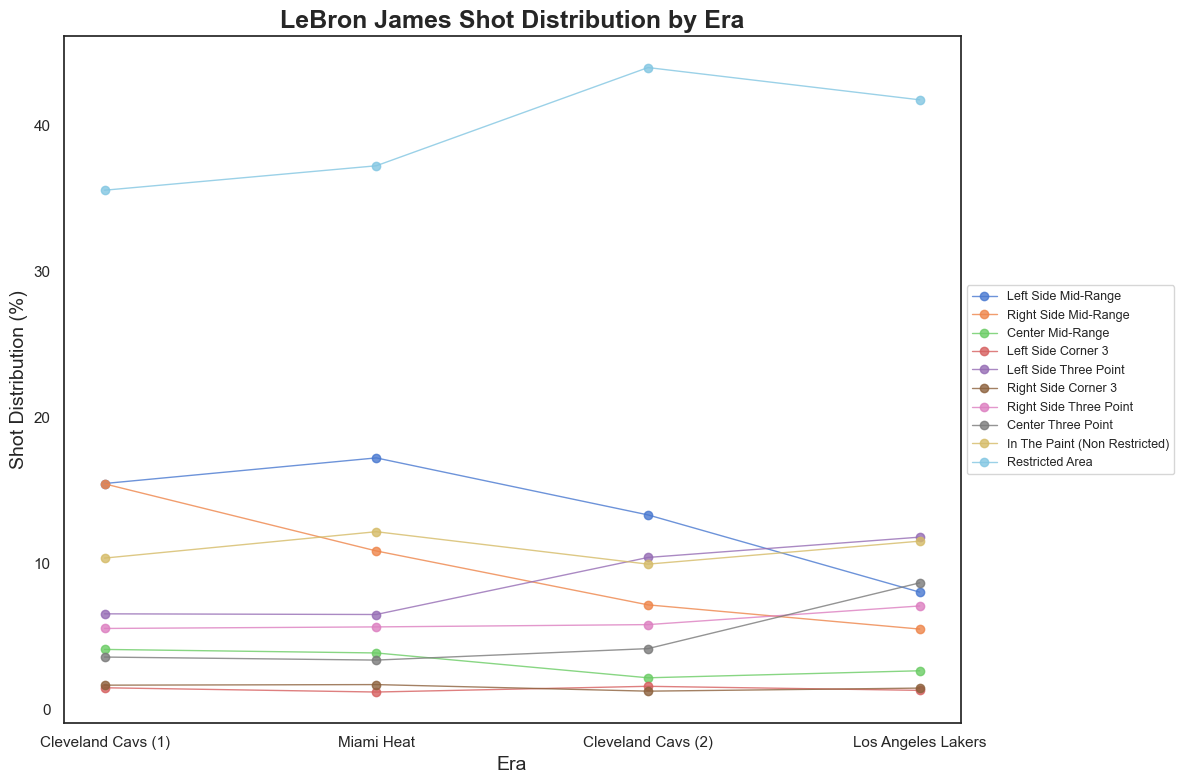

In [723]:
# Define shot distribution lists for each area
areas = [
    'Left Side Mid-Range', 'Right Side Mid-Range', 'Center Mid-Range',
    'Left Side Corner 3', 'Left Side Three Point', 'Right Side Corner 3',
    'Right Side Three Point', 'Center Three Point',
    'In The Paint (Non Restricted)', 'Restricted Area'
]

# Initialize empty lists for each area
area_distributions = {area: [] for area in areas}

# Append the values to the lists
for era in [distribution_cavs1, distribution_mia, distribution_cavs2, distribution_lal]:
    for area in areas:
        area_distributions[area].append(era[area])

# Set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data for each area
for area in areas:
    plt.plot(eras_label, area_distributions[area], marker='o', label=area, linestyle='solid', linewidth=1, alpha=0.8)

# Add labels and title
plt.xlabel('Era', fontsize=14)
plt.ylabel('Shot Distribution (%)', fontsize=14)
plt.title('LeBron James Shot Distribution by Era', fontsize=18, fontweight='bold')

# Add a legend
plt.legend(fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


As we can see, LeBron's shot selection has evolved significantly over the years. Early in his career, he relied heavily on mid-range jumpers and shots in the paint, with fewer attempts from beyond the arc. However, as his career progressed, he began to take more three-pointers, leading to a more balanced shot distribution across different areas of the court. While LeBron has always been a dominant force in the paint due to his physical attributes, his improved three-point shooting has made him an even more versatile and dangerous offensive player.

Specifically, we can see that LeBron has increased his shot attempts from the three-point line, particularly from the top of the key and the right wing, indicating significant improvement in his right-side shooting. Despite this, he still takes most of his shots from the left side of the court, where he appears more comfortable. This trend is consistent across all eras, suggesting that LeBron has developed a preference for shooting from the left side of the court, even as his overall shot selection has become more diverse over time.


## Efficiency

Now that we have analyzed LeBron's shot selection over the years, let's turn our attention to his shooting efficiency. In this section, we will examine LeBron's shooting percentages from different areas of the court and compare them across different eras to see how his efficiency has evolved over time.

The dataset contains information about the outcome of each shot attempt, including whether the shot was made or missed. We can use this data to calculate LeBron's shooting percentages from different areas of the court for each era and analyze how they have changed over time.

### Shooting Efficiency
This function takes the dataset and the eras dictionary as inputs and returns a DataFrame containing LeBron's shooting percentages from each area of the court for each era.

In [724]:
#Shooting Efficiency

#This function takes the dataset and as inputs and returns a DataFrame containing LeBron's shooting percentages from each area of the court for each era.

#input data: DataFrame, list of strings
#output: DataFrame

def shooting_efficiency(data, seasons):

    #Filter the data by the given seasons

    data = data[data.Season.isin(seasons)]

    #Get the total number of shots attempted for each area

    attemps = shots(data)

    #Get the total number of shots made for each area
    #let's use the same function to calculate the number of shots made for each area
    #first we have to filter the data by the shots made

    data = data[data.FG == 1]

    made = shots(data)

    #Create a dictionary with the shooting efficiency for each area
    efficiency = {area: made[area] / attemps[area] * 100 for area in attemps}

    return efficiency


At first glance, a box plot appears to be a suitable way to visualize LeBron's shooting efficiency for each era. Therefore, let's plot a box plot of LeBron's shooting efficiency during his time with the Cleveland Cavaliers from 2003-2004 to 2009-2010. This will help us understand the distribution and variability of his shooting performance during this period.

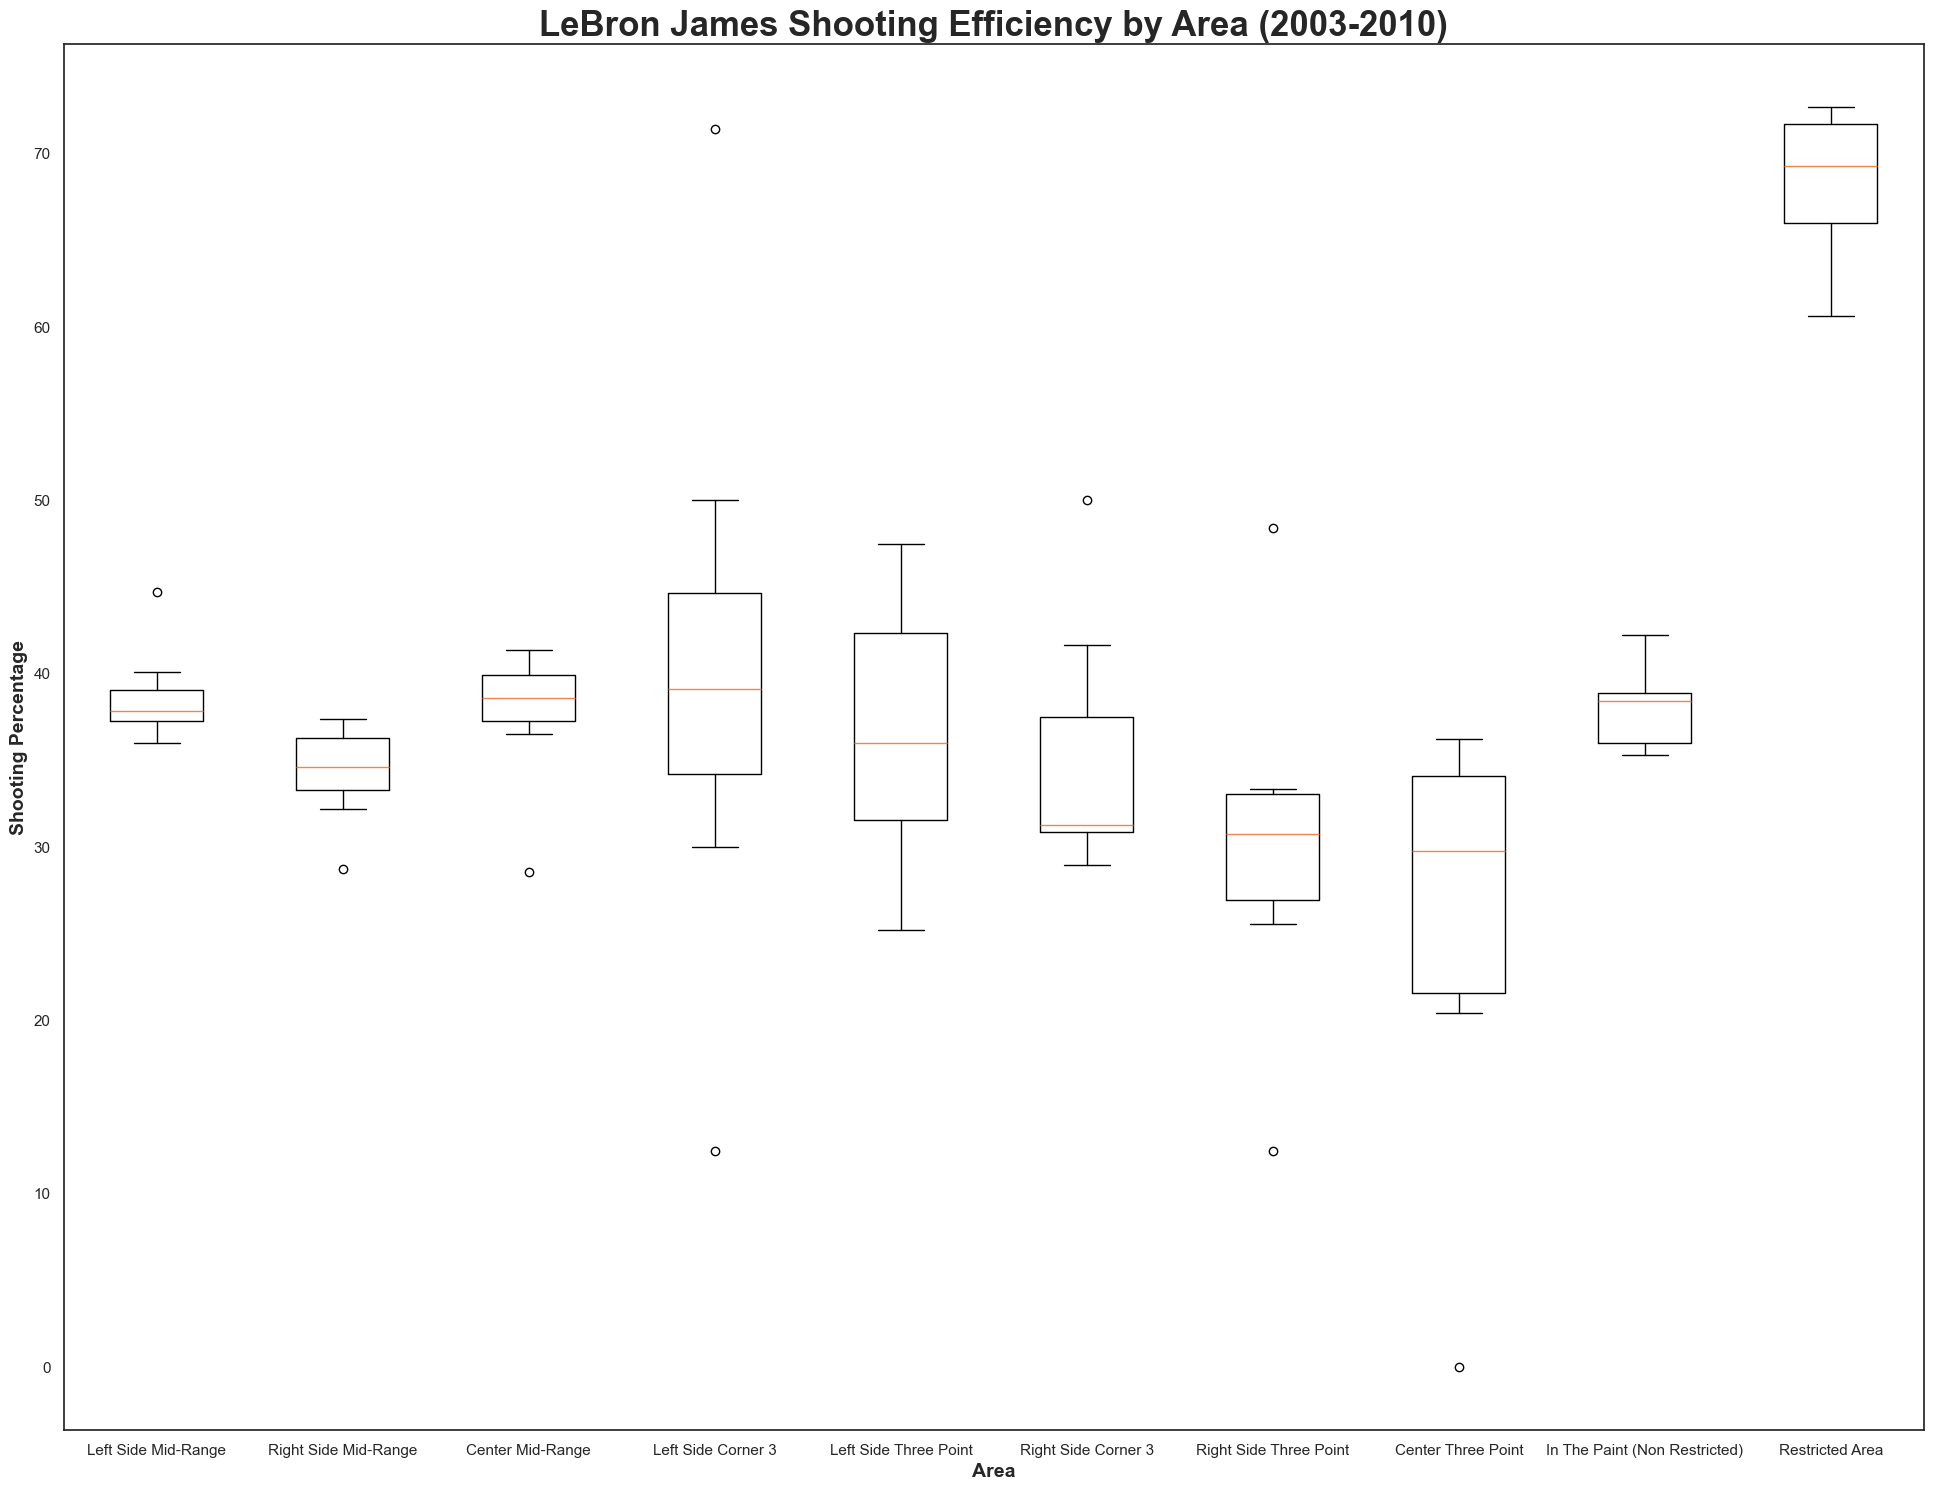

In [725]:
# Clear lists to ensure they are empty
Left_Side_Mid_Range.clear()
Right_Side_Mid_Range.clear()
Center_Mid_Range.clear()
Left_Side_Corner_3.clear()
Left_Side_Three_Point.clear()
Right_Side_Corner_3.clear()
Right_Side_Three_Point.clear()
Center_Three_Point.clear()
In_The_Paint_Non_Restricted.clear()
Restricted_Area.clear()

# Initialize a dictionary to hold efficiency data
efficiency_data = {
    'Left Side Mid-Range': Left_Side_Mid_Range,
    'Right Side Mid-Range': Right_Side_Mid_Range,
    'Center Mid-Range': Center_Mid_Range,
    'Left Side Corner 3': Left_Side_Corner_3,
    'Left Side Three Point': Left_Side_Three_Point,
    'Right Side Corner 3': Right_Side_Corner_3,
    'Right Side Three Point': Right_Side_Three_Point,
    'Center Three Point': Center_Three_Point,
    'In The Paint (Non Restricted)': In_The_Paint_Non_Restricted,
    'Restricted Area': Restricted_Area
}

# Iterate over seasons and calculate efficiency for each area
for season in cavs_1:
    efficiency = shooting_efficiency(df, [season])
    for area in efficiency_data:
        efficiency_data[area].append(efficiency[area])

# Set the size of the plot
fig, ax = plt.subplots(figsize=(24, 18))

# Plot the data as a boxplot
plt.boxplot(efficiency_data.values(), labels=efficiency_data.keys())

# Add labels and title
plt.xlabel('Area', fontsize=14, fontweight='bold')
plt.ylabel('Shooting Percentage', fontsize=14, fontweight='bold')
plt.title('LeBron James Shooting Efficiency by Area (2003-2010)', fontsize=25, fontweight='bold')

plt.show()


To be fair, this type of plot doesn't clearly illustrate LeBron's shooting efficiency due to the numerous areas it covers. However, it does highlight an important trend: LeBron is very inconsistent from the three-point line, with many outliers in his shooting efficiency. This aligns with the fact that LeBron has never been a great three-point shooter, but rather a player who can make threes when necessary. Further analysis on this aspect will be provided later in the study.

A clearer view of James' shooting efficiency evolution can be obtained by plotting a line graph of his shooting percentages from various distances from the hoop. Specifically, for each era, we will plot two lines: one for his shots from the left side and one for his shots from the right side.

In [726]:
#Shooting Efficiency by Distance

#This function takes the dataset and a list of seasons as inputs and returns a list of shooting percentages for each distance range.

#input data: DataFrame, list of strings
#output: list of floats

def shooting_efficiency_distance(data, seasons):
    efficiency = []
    data = data[data.Season.isin(seasons)]

    for i in range(0, 30):
        
        attempts = data[data.Distance == i].shape[0]
        made = data[(data.Distance == i) & (data.FG == 1)].shape[0]
        efficiency.append(made / attempts * 100)

    return efficiency

In [727]:
#some useful constants that will be used to create the distance ranges

efficiency_l = []
efficiency_r = []

distances = np.arange(0, 30)

In [728]:
# Define distance ranges and corresponding colors/texts
distances_ranges = np.array([ (0, 3), (3, 15), (8, 23.5), (23.5, 31), (22, 25)])

colors_ranges = np.array(['red', 'blue', 'green', 'purple', 'orange'])

colors_text = np.array(['Restricted Area', 'In The Paint (Non Restricted)', 'Mid-Range', 'Three Point', 'Corner Three'])

# Function to plot shot zones based on distance ranges

def plot_dist(ax):
    for i, (start, end) in enumerate(distances_ranges):
        ax.axvspan(start, end, color=colors_ranges[i], alpha=0.05)
        ax.text((start + end) / 2, 8, colors_text[i], fontsize=7, ha='center', color='black')



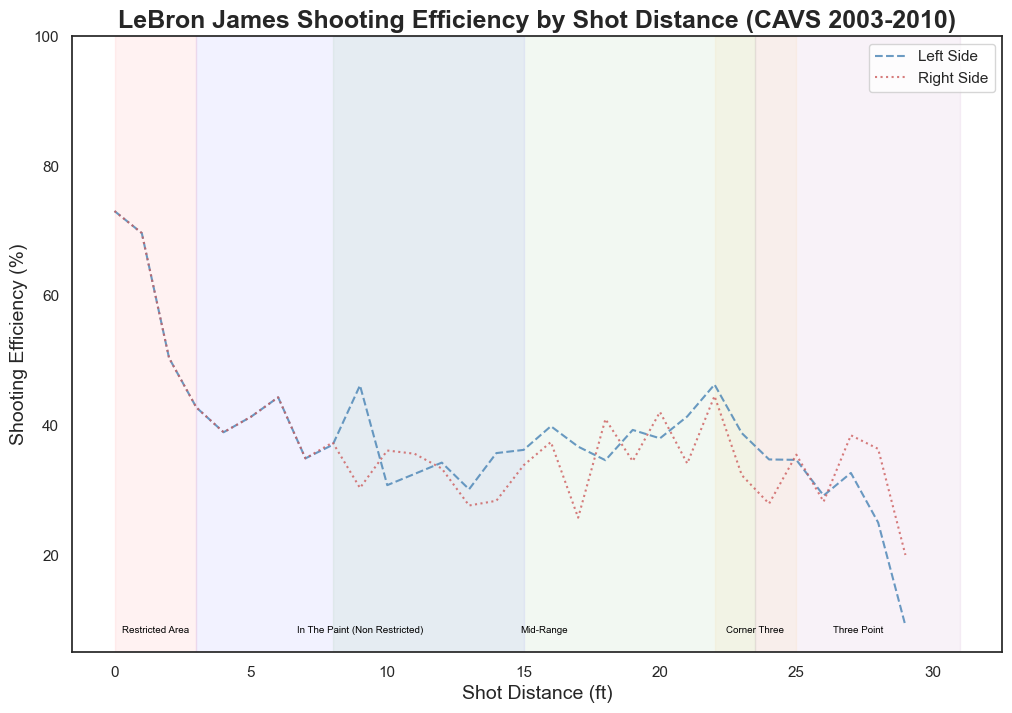

In [729]:
# scatter plot of correlation between shooting efficiency and shot distance
# plot a line for the left and one for the right side


df_l = df[(df.Area == 'Left Side(L)') | (df.Area == 'Center(C)')]
df_r = df[(df.Area == 'Right Side(R)') | (df.Area == 'Center(C)')]

#calculate the shooting efficiency for the left side
efficiency_l = shooting_efficiency_distance(df_l, cavs_1)

#calculate the shooting efficiency for the right side
efficiency_r = shooting_efficiency_distance(df_r, cavs_1)


#set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

#plot the data
plt.plot(range(0, 30), efficiency_l, label='Left Side', color='steelblue', alpha=0.8, linestyle='dashed')
plt.plot(range(0, 30), efficiency_r, label='Right Side', color='indianred', alpha=0.8, linestyle='dotted')

#y axis limits
plt.ylim(5, 100)

#plot the distance ranges
plot_dist(ax)

#add labels and title
plt.xlabel('Shot Distance (ft)', fontsize=14)
plt.ylabel('Shooting Efficiency (%)', fontsize=14)
plt.title('LeBron James Shooting Efficiency by Shot Distance (CAVS 2003-2010)', fontsize=18, fontweight='bold')

#add legend
plt.legend()

plt.show()


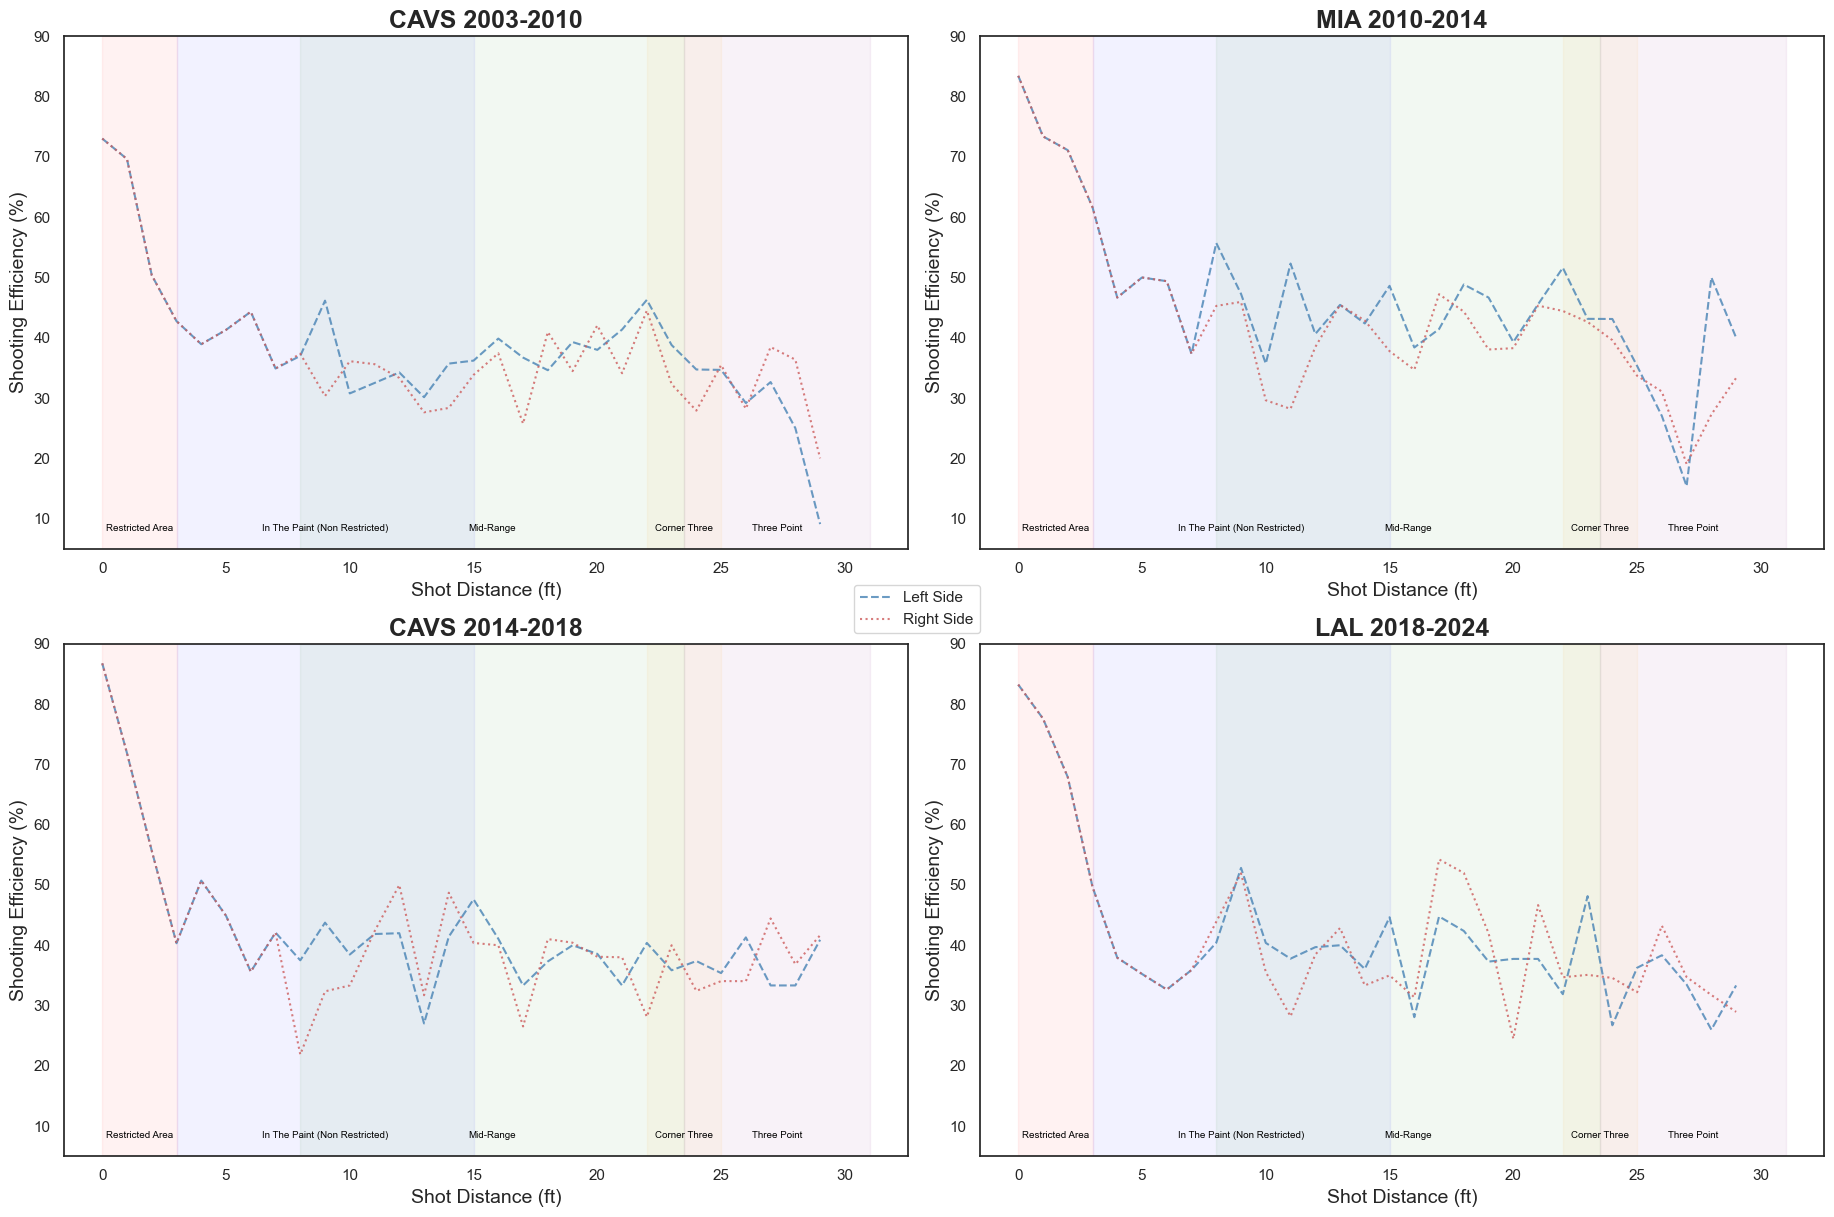

In [730]:
#Define a function to calculate and plot shooting efficiency
def plot_efficiency(ax, title, team_data, df):
    df_l = df[(df.Area == 'Left Side(L)') | (df.Area == 'Center(C)')]
    df_r = df[(df.Area == 'Right Side(R)') | (df.Area == 'Center(C)')]

    efficiency_l = shooting_efficiency_distance(df_l, team_data)
    efficiency_r = shooting_efficiency_distance(df_r, team_data)

    ax.plot(range(0, 30), efficiency_l, label='Left Side', color='steelblue', alpha=0.8, linestyle='dashed')
    ax.plot(range(0, 30), efficiency_r, label='Right Side', color='indianred', alpha=0.8, linestyle='dotted')

    ax.set_ylim(5, 90)
    plot_dist(ax)
    ax.set_xlabel('Shot Distance (ft)', fontsize=14)
    ax.set_ylabel('Shooting Efficiency (%)', fontsize=14)
    ax.set_title(title, fontsize=18, fontweight='bold')

# Create the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(18.5, 12.33))

# Plot the shooting efficiency for each era
plot_efficiency(axs[0, 0], 'CAVS 2003-2010', cavs_1, df)
plot_efficiency(axs[0, 1], 'MIA 2010-2014', mia, df)
plot_efficiency(axs[1, 0], 'CAVS 2014-2018', cavs_2, df)
plot_efficiency(axs[1, 1], 'LAL 2018-2024', lal, df)

# Add a legend
fig.legend(['Left Side', 'Right Side'], loc='upper center', fontsize=11, bbox_to_anchor=(0.5, 0.525), bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.show()


The graph clearly shows that LeBron's shooting efficiency has improved over the years, especially from the three-point line. In the early stages of his career, LeBron struggled with three-point shooting, but he has steadily improved, becoming a more reliable shooter from long range. Notably, his efficiency has become more consistent in the last two eras, indicating that he has become more dependable from beyond the arc, despite taking more shots from there than in the past.

Another interesting observation is his preference for the left side of the court, where he has been more efficient throughout his career. However, his efficiency from the right side has significantly improved since his return to Cleveland in 2014, suggesting that he has worked on his right-side shooting to become a more balanced scorer.

In [731]:
#shooting efficiency by season behind the arc

#This function takes the dataset and a list of seasons as inputs and returns a list of shooting percentages for each season

#input data: DataFrame
#output: list of floats

def shooting_efficiency_season(data, seasons):
    efficiency = []

    for season in seasons:
        attempts = data[data.Season == season].shape[0]
        made = data[(data.Season == season) & (data.FG == 1)].shape[0]
        efficiency.append(made / attempts * 100)

    return efficiency

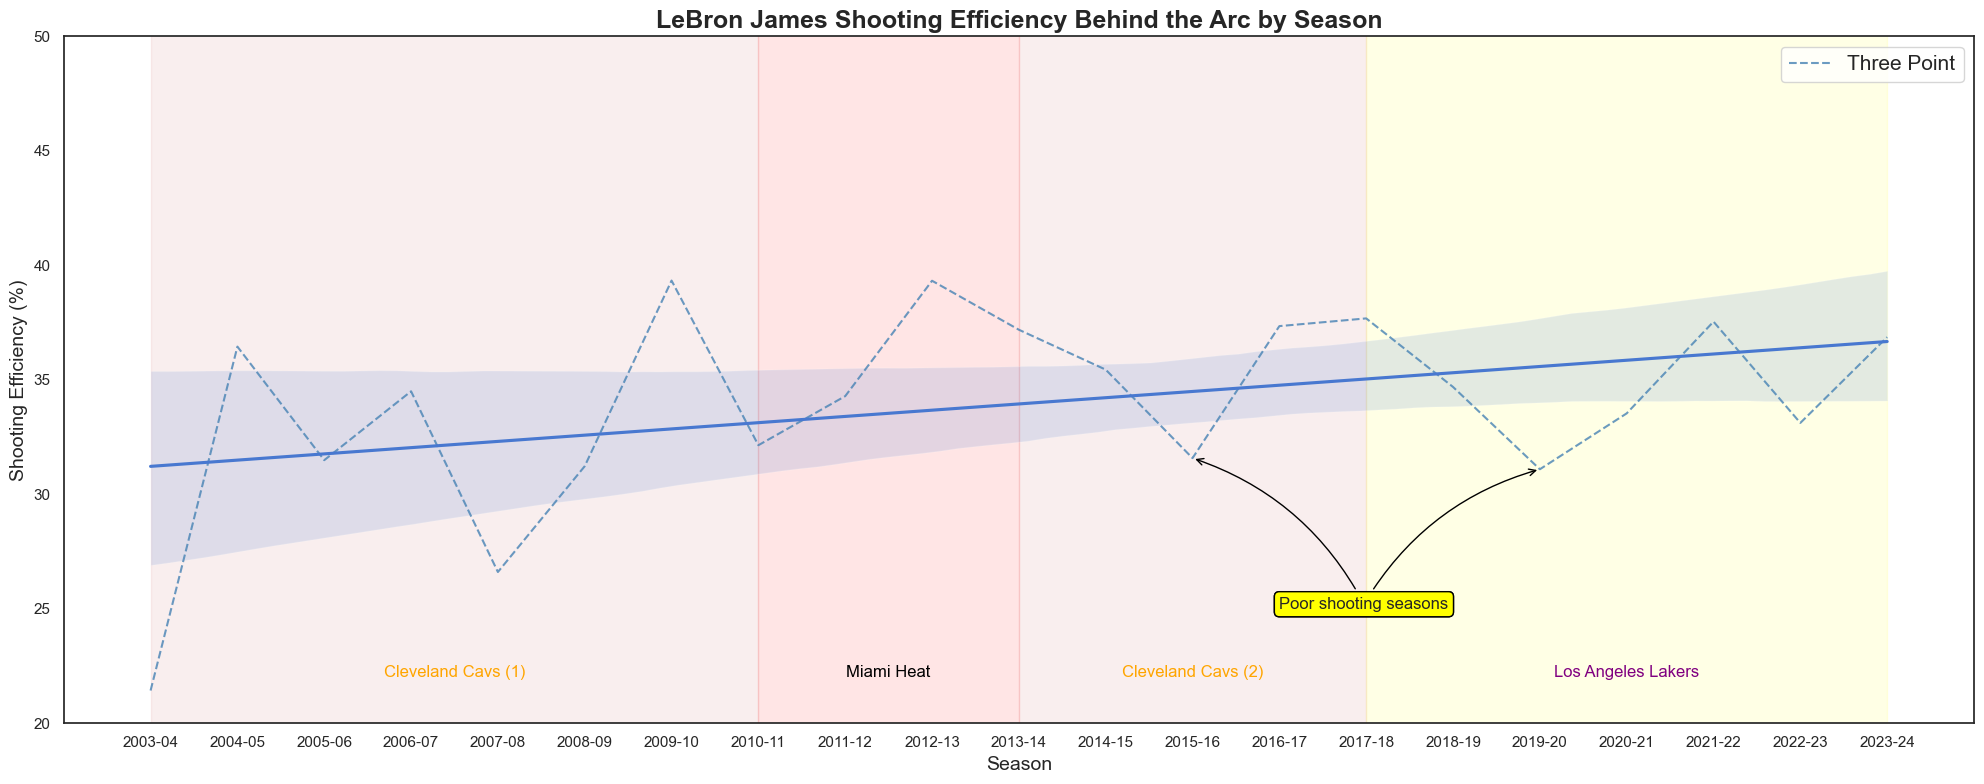

In [732]:
# Clear lists for shooting efficiency
efficiency_l.clear()
efficiency_r.clear()

# Create numeric seasons list
seasons_numeric = list(range(0, 21))

# Filter data for above the break 3 shots
df_threes = df[df.Zone == 'Above the Break 3']

# Calculate shooting efficiency for above the break 3 shots
efficiency = shooting_efficiency_season(df_threes, seasons)

# Set the size of the plot
fig, ax = plt.subplots(figsize=(20, 8))
plt.ylim(20, 50)

# Plot the data for three-point shooting efficiency
plt.plot(seasons, efficiency, label='Three Point', color='steelblue', alpha=0.8, linestyle='dashed')

# Define eras and their respective plot areas with colors and text
eras = [
    ('Cleveland Cavs (1)', 0, 7, 'indianred'),
    ('Miami Heat', 7, 10, 'red'),
    ('Cleveland Cavs (2)', 10, 14, 'indianred'),
    ('Los Angeles Lakers', 14, 20, 'yellow')
]

text_color = ['orange', 'black', 'orange', 'purple']

# Plot shaded areas and labels for each era
for era, d, d2, color in eras:
    plt.fill_between([d, d2], 0, 100, color=color, alpha=0.1)
    plt.text((d + d2) / 2, 22, era, fontsize=12, ha='center', color=text_color[eras.index((era, d, d2, color))])

# Add labels and title
plt.xlabel('Season', fontsize=14)
plt.ylabel('Shooting Efficiency (%)', fontsize=14)
plt.title('LeBron James Shooting Efficiency Behind the Arc by Season', fontsize=18, fontweight='bold')

# Add legend
plt.legend(loc='upper right', fontsize=15)

# Annotate poor shooting seasons
plt.annotate('Poor shooting seasons', xy=(12, efficiency[12]), xytext=(13, 25), fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='black'),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow'))

# Add symmetric arrow annotation
plt.annotate('Poor shooting seasons', xy=(16, efficiency[16]), xytext=(13, 25), fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2", color='black'),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow'))

# Plot regression line using seaborn
sns.regplot(x=seasons_numeric, y=efficiency, scatter=False, ax=ax, line_kws={"color": "b"})

plt.tight_layout()
plt.show()


In [733]:
#Effective Field Goal Percentage

#efg = fg + 0.5 * threes_made / attemps

#This function takes the dataset and a list of seasons as inputs and returns a list of effective field goal percentages for each season.

#input data: DataFrame, list of strings
#output: list of floats

def calculate_efg(data, seasons):
    efg = []

    for season in seasons:
        df_season = data[data.Season == season]
        fg = df_season[df_season.FG == 1].shape[0]
        threes_made = df_season[(df_season.FG == 1) & (df_season.Zone == 'Above the Break 3')].shape[0]
        attemps = df_season.shape[0]
        efg.append((fg + 0.5 * threes_made) / attemps * 100)

    return efg

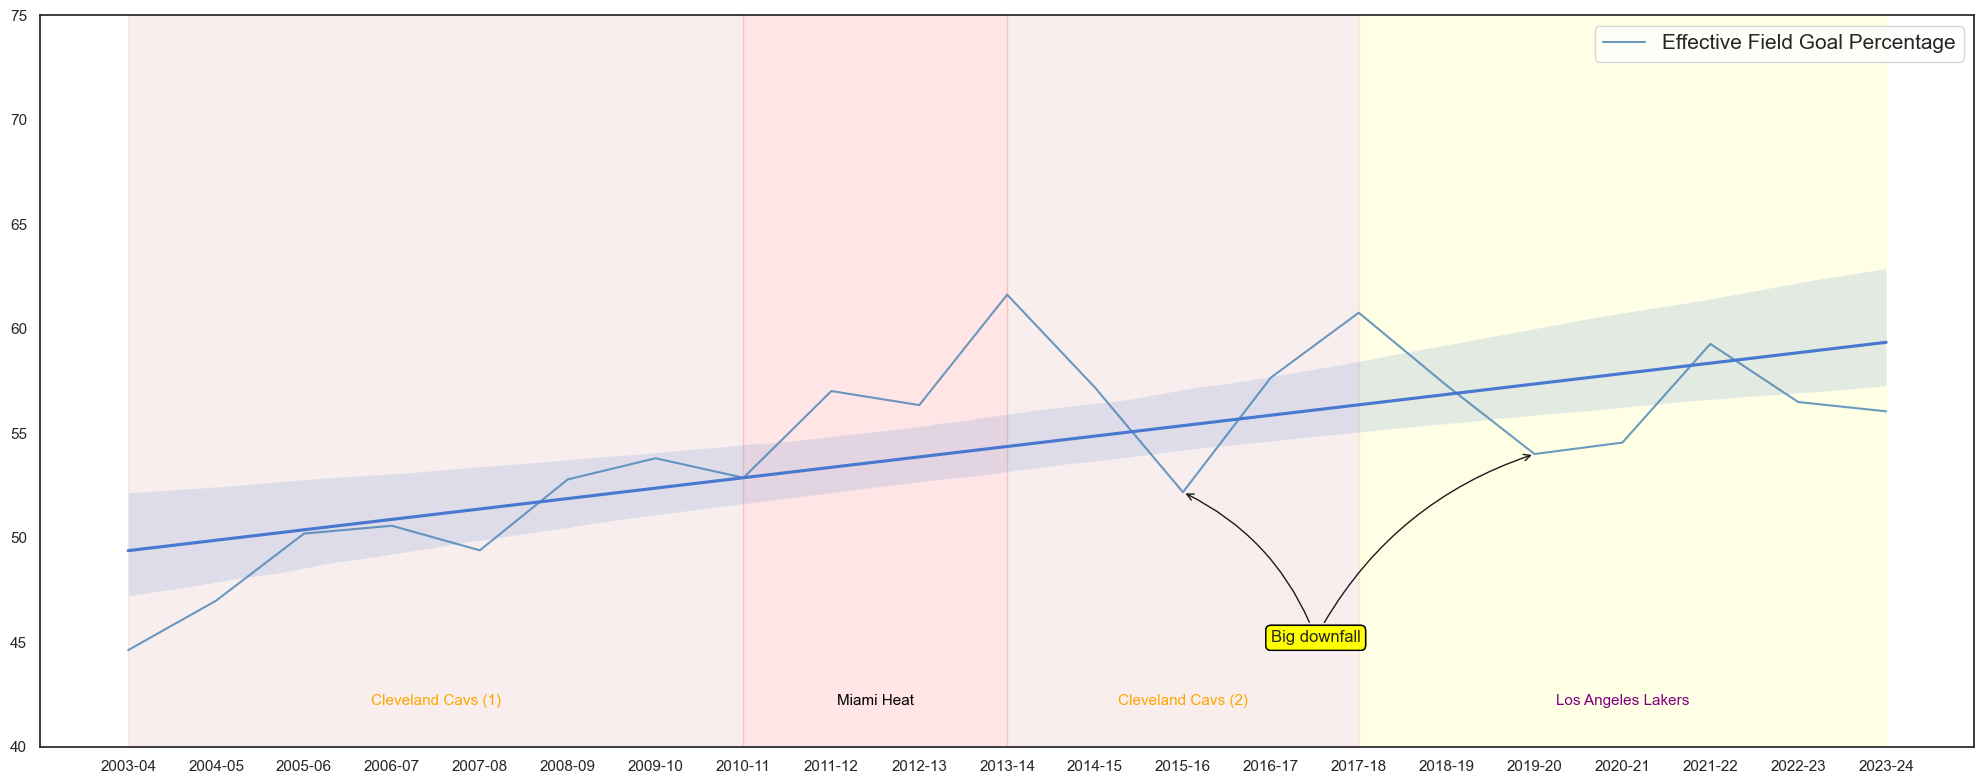

In [734]:
# Supponiamo che la funzione calculate_efg sia già definita e restituisca i dati necessari
efg = calculate_efg(df, seasons)  # Utilizziamo range(0, 20) per rappresentare le stagioni

# Converti range(0, 20) in una lista di numeri interi
seasons_numeric = list(range(0, 21))


# Imposta la dimensione del grafico
fig, ax = plt.subplots(figsize=(20, 8))

# Limiti dell'asse y
plt.ylim(40, 75)

# Plot the data for three-point shooting efficiency
plt.plot(seasons, efg, label='Effective Field Goal Percentage', color='steelblue', alpha=0.8, linestyle='-')

# Define eras and their respective plot areas with colors and text
eras = [
    ('Cleveland Cavs (1)', 0, 7, 'indianred'),
    ('Miami Heat', 7, 10, 'red'),
    ('Cleveland Cavs (2)', 10, 14, 'indianred'),
    ('Los Angeles Lakers', 14, 20, 'yellow')
]

text_color = ['orange', 'black', 'orange', 'purple']

for era, d, d2, color in eras:
    plt.fill_between([d, d2], 0, 100, color=color, alpha=0.1)
    plt.text((d + d2) / 2, 42, era, fontsize=11, ha='center', color=text_color[eras.index((era, d, d2, color))])


# Add legend
plt.legend(loc='upper right', fontsize=15)

# Annotate poor shooting seasons
plt.annotate('Big downfall', xy=(12, efg[12]), xytext=(13, 45), fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='k'),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow'))

plt.annotate('Big downfall', xy=(16, efg[16]), xytext=(13, 45), fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2", color='k'),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow'))
# Plot regression line using seaborn
sns.regplot(x=seasons_numeric, y=efg, scatter=False, ax=ax, line_kws={"color": "b"})

plt.tight_layout()
plt.show()


In [735]:
#correlazione tra efg e usage rate



#This function takes the dataset and a list of seasons as inputs and returns the correlation coefficient between the effective field goal percentage and the usage rate for each season.
#prende l'efg dalla funzione precedente calcolata sul primo df e l'usage dal secondo df

#input data: DataFrame, Dataframe, list of strings
#output: float

def correlation_efg_usage(data, data2, seasons):
    efg = calculate_efg(data, seasons)
    usage = data2[data2.Season.isin(seasons)]['USG']
    return np.corrcoef(efg, usage)[0, 1]

print(correlation_efg_usage(df, df2, seasons))


#correlazione tra usg e TS

#This function takes the dataset and a list of seasons as inputs and returns the correlation coefficient between the usage rate and the true shooting percentage for each season.

#input data: DataFrame, list of strings
#output: float

def correlation_usg_ts(data, seasons):
    usage = data[data.Season.isin(seasons)]['USG']
    ts = data[data.Season.isin(seasons)]['TS']
    return np.corrcoef(usage, ts)[0, 1]

print(correlation_usg_ts(df2, seasons))


0.2676824168099239
0.1284730367619482


In [736]:
#correlazione tra efg e plus minus

#This function takes the dataset and a list of seasons as inputs and returns the correlation coefficient between the effective field goal percentage and the plus-minus for each season.

#input data: DataFrame, list of strings
#output: float

def correlation_efg_pm(data, data2, seasons):

    efg = calculate_efg(data, seasons)
    pm = data2[data2.Season.isin(seasons)]['RPM']
    return np.corrcoef(efg, pm)[0, 1]

print(correlation_efg_pm(df, df2, seasons))


#correlazione tra ts e plus minus

#This function takes the dataset and a list of seasons as inputs and returns the correlation coefficient between the true shooting percentage and the plus-minus for each season.

#input data: DataFrame, list of strings

#output: float

def correlation_ts_pm(data, seasons):
    ts = data[data.Season.isin(seasons)]['TS']
    pm = data[data.Season.isin(seasons)]['RPM']
    return np.corrcoef(ts, pm)[0, 1]

print(correlation_ts_pm(df2, seasons))


0.18231485353327076
0.29993876823642734


In [737]:
#This function takes the dataset and a list of seasons as inputs and returns the correlation coefficient between the shot distance and the shooting efficiency for each season.

#input data: DataFrame, list of strings
#output: float

def correlation_distance_efficiency(data, seasons):
    efficiency = []
    efficiency = shooting_efficiency_distance(data, seasons)
    distances = np.arange(0, 30)
    return np.corrcoef(distances, efficiency)[0, 1]

print(correlation_distance_efficiency(df, cavs_1))
print(correlation_distance_efficiency(df, mia))
print(correlation_distance_efficiency(df, cavs_2))
print(correlation_distance_efficiency(df, lal))


#correlazione negativa medio-forte tra distanza e efficienza di tiro

-0.6371182225693237
-0.7746830649191123
-0.5462013896049668
-0.5827765247306257


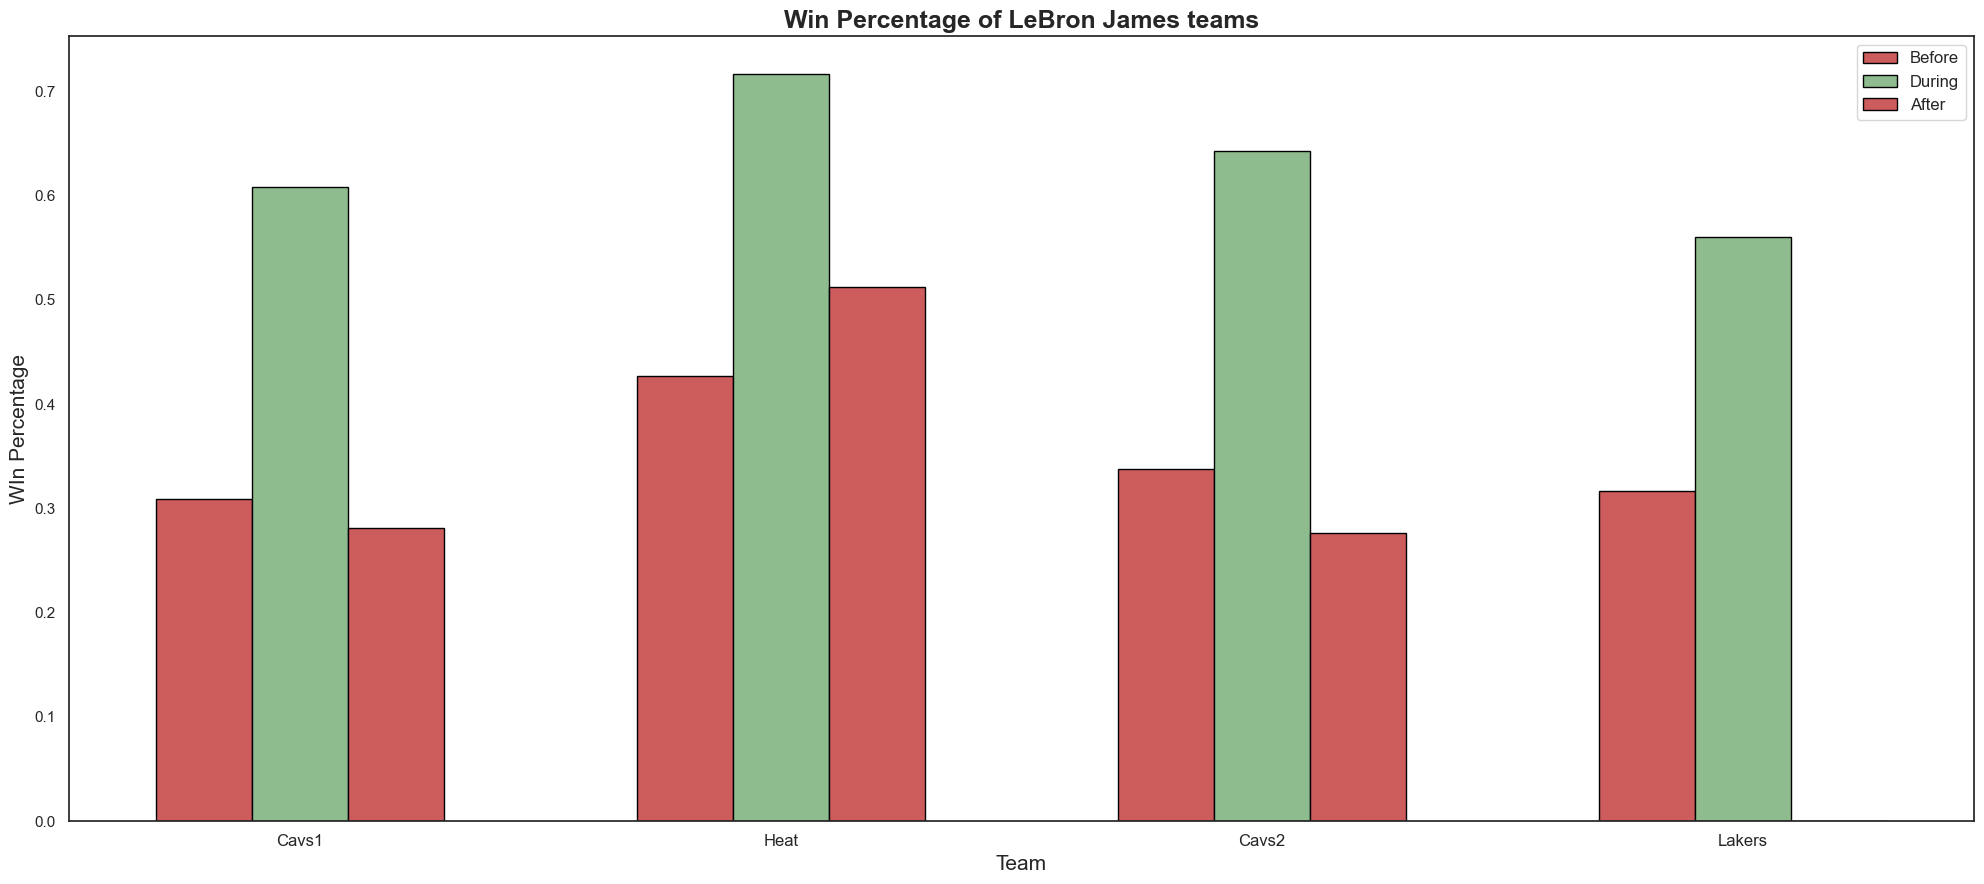

In [738]:
# Definizione dei colori neutri (scala di blu)
colors = {
    'before': 'indianred',
    'with': 'darkseaGreen',
    'after': 'indianred'
}

# Funzione per scegliere il colore in base al periodo
def color_era(period):
    return colors[period]

# Creazione del bar plot con i colori neutri
fig, ax = plt.subplots(figsize=(20, 9))

# Per ogni squadra, plottiamo la percentuale di vittorie per periodo
bar_width = 0.2
positions = []

for i, team in enumerate(df_Mean.index):
    periods = df_Mean.columns
    for j, period in enumerate(periods):
        bar_position = i + j * bar_width
        positions.append(bar_position)
        ax.bar(bar_position, df_Mean.loc[team, period], bar_width, color=color_era(period), edgecolor='black')

# Configurazione delle etichette sull'asse x
ax.set_xticks([i + bar_width for i in range(len(df_Mean.index))])
ax.set_xticklabels(df_Mean.index, rotation=0, fontsize=12)

# size delle etichette sull'asse x



# Aggiunta delle etichette
ax.set_xlabel('Team', fontsize=15)
ax.set_ylabel('WIn Percentage', fontsize=15)
ax.set_title('Win Percentage of LeBron James teams', fontsize=18, fontweight='bold')


#add a legend
ax.legend(['Before', 'During', 'After'], loc='upper right', fontsize=12)


# Mostra il grafico
plt.tight_layout()
plt.show()


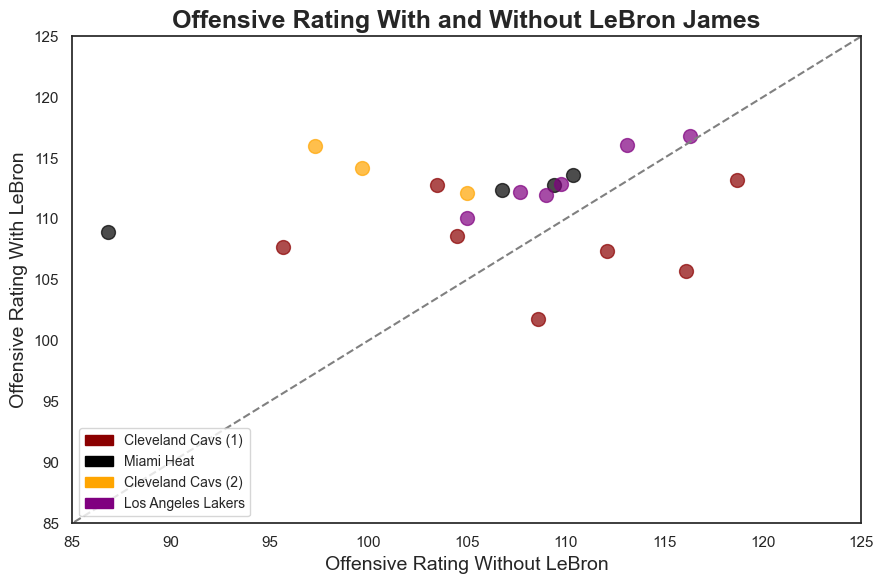

In [739]:
#scatter plot of offensive rating with and without lebron

#Function that plot the offensive rating with and without LeBron James
# x: offensive rating without LeBron
# y: offensive rating with LeBron
#change color of the points based on the era
#darkred: cavalliers 2003-2010
#black: Miami Heat
#orange: Cavaliers 2014-2018
#purple: Los Angeles Lakers

#aggiungo la distribuzione normale sugli assi

def plot_offensive_rating(data, seasons):
    # Filter the data by the given seasons
    data = data[data.Season.isin(seasons)]

    # Get the offensive rating without LeBron James
    off_rating_without = data['OFR_T']

    # Get the offensive rating with LeBron James
    off_rating_with = data['OFR_L']

    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(9, 6))

    # Plot the data
    for i in range(len(off_rating_without)):
        color = 'darkred' if seasons[i] in cavs_1 else 'black' if seasons[i] in mia else 'orange' if seasons[i] in cavs_2 else 'purple'
        ax.scatter(off_rating_without.iloc[i], off_rating_with.iloc[i], color=color, s=100, alpha=0.7)

    # Add labels and title
    ax.set_xlabel('Offensive Rating Without LeBron', fontsize=14)
    ax.set_ylabel('Offensive Rating With LeBron', fontsize=14)
    ax.set_title('Offensive Rating With and Without LeBron James', fontsize=18, fontweight='bold')

    # Add a legend
    legend_handles = [
        patches.Patch(color='darkred', label='Cleveland Cavs (1)'),
        patches.Patch(color='black', label='Miami Heat'),
        patches.Patch(color='orange', label='Cleveland Cavs (2)'),
        patches.Patch(color='purple', label='Los Angeles Lakers')
    ]

    #set lim
    ax.set_xlim(85, 125)
    ax.set_ylim(85, 125)

    #add bisector line
    ax.plot([80, 130], [80, 130], color='gray', linestyle='dashed')

    ax.legend(handles=legend_handles, loc='lower left', fontsize=10)


    plt.tight_layout()
    plt.show()


# Plot the offensive rating with and without LeBron James for each era
plot_offensive_rating(df2, seasons)

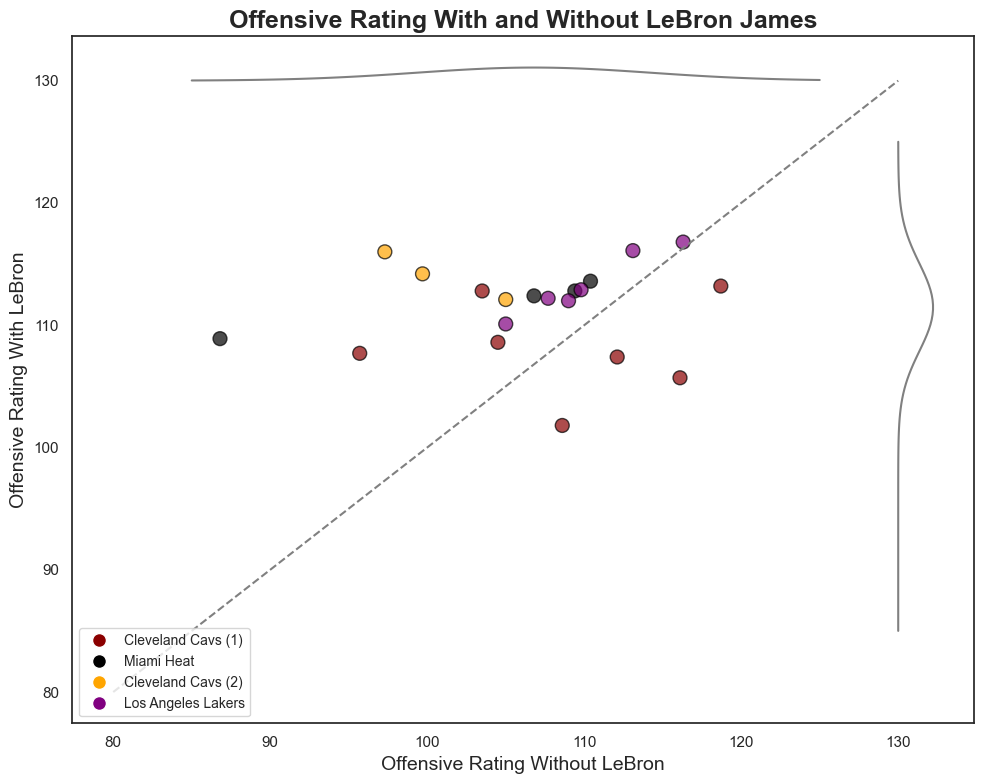

In [744]:
from scipy.stats import norm

def plot_offensive_rating(data, seasons):
    # Filter the data by the given seasons
    data = data[data.Season.isin(seasons)]

    # Get the offensive rating without LeBron James
    off_rating_without = data['OFR_T']

    # Get the offensive rating with LeBron James
    off_rating_with = data['OFR_L']

    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    colors = ['darkred' if season in cavs_1 else 'black' if season in mia else 'orange' if season in cavs_2 else 'purple' for season in seasons]
    
    ax.scatter(off_rating_without, off_rating_with, color=colors, s=100, alpha=0.7, edgecolor='black')

    # Add labels and title
    ax.set_xlabel('Offensive Rating Without LeBron', fontsize=14)
    ax.set_ylabel('Offensive Rating With LeBron', fontsize=14)
    ax.set_title('Offensive Rating With and Without LeBron James', fontsize=18, fontweight='bold')

    # Add a legend
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=10, label='Cleveland Cavs (1)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Miami Heat'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Cleveland Cavs (2)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Los Angeles Lakers')
    ]

    ax.legend(handles=legend_handles, loc='lower left', fontsize=10)

    # Add a bisector line
    ax.plot([80, 130], [80, 130], color='gray', linestyle='dashed')

    # Add normal distribution lines
    x = np.linspace(85, 125, 100)
    mu_x, std_x = np.mean(off_rating_without.dropna()), np.std(off_rating_without.dropna())
    mu_y, std_y = np.mean(off_rating_with.dropna()), np.std(off_rating_with.dropna())
    ax.plot(x, norm.pdf(x, mu_x, std_x)*20 + 130, color='gray', linestyle='solid', linewidth=1.5)
    ax.plot(norm.pdf(x, mu_y, std_y)*20 + 130, x, color='gray', linestyle='solid', linewidth=1.5)

    plt.tight_layout()
    plt.show()

# Plot the offensive rating with and without LeBron James for each era
plot_offensive_rating(df2, seasons)



C:\Users\fbort\AppData\Roaming\Python\Python312\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


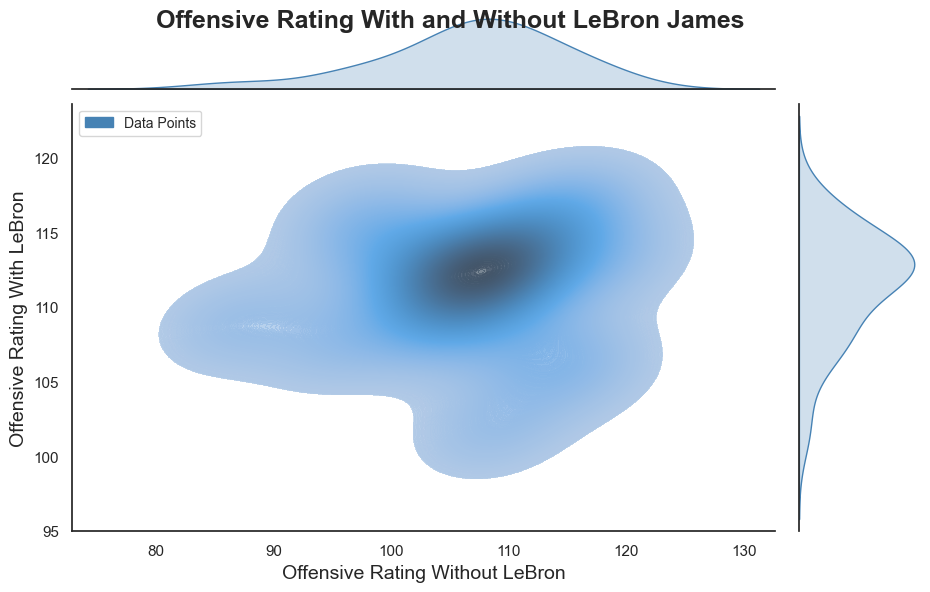

In [741]:
df2.reset_index(inplace=True)
plot = sns.jointplot(x=df2.OFR_T, y=df2.OFR_L, kind='kde', color='steelblue', fill= True ,s=100, alpha=0.7, n_levels=1000)

# Set the size of the plot
plot.fig.set_figwidth(10)

# Add labels and title
plot.set_axis_labels('Offensive Rating Without LeBron', 'Offensive Rating With LeBron', fontsize=14)
plot.fig.suptitle('Offensive Rating With and Without LeBron James', fontsize=18, fontweight='bold')

# Add a legend
legend_handles = [
    patches.Patch(color='steelblue', label='Data Points')
]

plot.ax_joint.legend(handles=legend_handles, loc='upper left', fontsize=10)

plt.show()